In [1]:
import torch
import torch.utils
import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Загрузка данных

In [5]:
cifar10_train = tv.datasets.CIFAR10(root=".", train=True, transform=tv.transforms.ToTensor(), download=True)
cifar10_test = tv.datasets.CIFAR10(root=".", train=False, transform=tv.transforms.ToTensor(), download=True)
print(len(cifar10_train), len(cifar10_test))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


### Тензоры уже привидены к формату от 0 до 1

In [6]:
cifar10_test[0][0][0][:1]

tensor([[0.6196, 0.6235, 0.6471, 0.6510, 0.6275, 0.6118, 0.6353, 0.6235, 0.6196,
         0.6235, 0.6314, 0.6275, 0.6314, 0.6510, 0.6627, 0.6667, 0.6549, 0.6353,
         0.6275, 0.6275, 0.6118, 0.5843, 0.5882, 0.5804, 0.5843, 0.5608, 0.5490,
         0.5529, 0.5608, 0.5373, 0.4941, 0.4549]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.6156863].


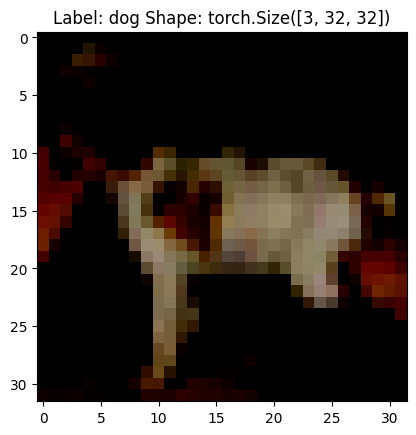

In [21]:
classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
image, label = cifar10_test[12]

plt.title(f"Label: {classes[label]} Shape: {image.shape}")
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

In [8]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(cifar10_train, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(cifar10_test, shuffle=False, batch_size=batch_size)

# Linear Neural Network

In [15]:
class LinearNN(nn.Module):
    def __init__(self):
        super(LinearNN, self).__init__()
        self.linear1 = nn.Linear(in_features=32*32*3, out_features=2048)
        self.linear2 = nn.Linear(in_features=2048, out_features=512)
        self.linear3 = nn.Linear(in_features=512, out_features=10)
        self.act1 = nn.ReLU()
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.act1(self.linear1(x))
        x = self.drop(self.act1(self.linear2(x)))
        out = self.linear3(x)
        return out

base_model = LinearNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.01)

# Обучение полносвязанной сети

In [ ]:
EPOCHS = 50
train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    # Тренировка
    train_progressbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")
    base_model.train()  # Переводим модель в режим тренировки
    running_train_accuracy = 0

    for idx, (imgs, labels) in enumerate(train_progressbar):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs = imgs.view(-1, 32*32*3)
        optimizer.zero_grad()

        predicts = base_model(imgs)
        loss = loss_fn(predicts, labels)
        loss.backward()
        optimizer.step()

        accuracy = accuracy_score([i.argmax().item() for i in predicts], labels)
        running_train_accuracy += accuracy

        if idx % 32 == 0:
            train_progressbar.set_description(f"Epoch [{epoch+1}/{EPOCHS}] Loss {loss.item():.4f} Accuracy {accuracy:.4f}")
    
    # Средняя точность на обучающей выборке за эпоху
    train_acc.append(running_train_accuracy / len(train_loader))
    
    # Валидация
    base_model.eval()  # Переводим модель в режим оценки
    running_test_accuracy = 0
    with torch.no_grad():  # Отключаем градиенты для валидации
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs.view(-1, 32*32*3)

            # Получаем предсказания
            predicts = base_model(imgs)

            accuracy = accuracy_score([i.argmax().item() for i in predicts], labels)
            running_test_accuracy += accuracy

    # Средняя точность на тестовой выборке за эпоху
    test_acc.append(running_test_accuracy / len(test_loader))
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Accuracy: {train_acc[-1]:.4f} Test Accuracy: {test_acc[-1]:.4f}")


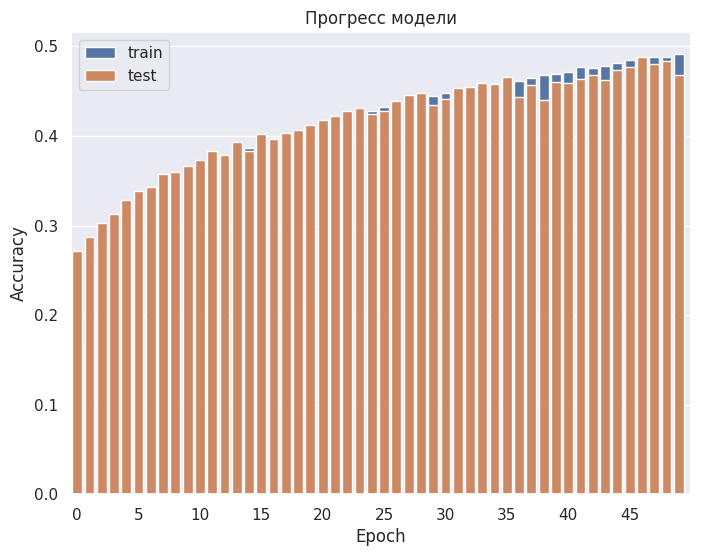

In [30]:
sns.set_theme()
plt.figure(figsize=(8, 6))
plt.title("Прогресс перцептронной модели")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
sns.barplot(train_acc, label="train")
sns.barplot(test_acc, label="test")
plt.legend()
plt.xticks([i for i in range(0, 51, 5)])
plt.show()

# Маленькая сверточная сеть, Adam, Softmax

In [ ]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3, 3), padding=1)
        self.pool1 = nn.MaxPool2d(stride=(2, 2), kernel_size=(4, 4))

        self.linear1 = nn.Linear(in_features=2250, out_features=100)
        self.linear2 = nn.Linear(in_features=100, out_features=10)

        self.act1 = nn.ReLU()
        self.act2 = nn.Softmax()

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = nn.Flatten()(x)
        x = self.act1(self.linear1(x))
        out = self.act2(self.linear2(x))
        return out

conv_model = ConvNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=conv_model.parameters(), lr=0.001)

In [90]:
EPOCHS = 10
train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    conv_model.train()
    train_progressbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")
    for idx, (imgs, labels) in enumerate(train_progressbar):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        predicts = conv_model(imgs)
        loss = loss_fn(predicts, labels)
        loss.backward()
        optimizer.step()
        
    
        accuracy = accuracy_score([i.argmax().item() for i in predicts], labels)

        if idx % 32 == 0:
            train_progressbar.set_description(f"TRAIN Epoch [{epoch+1}/{EPOCHS}] Loss {loss.item():.4f} Accuracy {accuracy:.4f}")

    train_acc.append(accuracy)
    conv_model.eval()  
    with torch.no_grad():  
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            predicts = conv_model(imgs)

            accuracy = accuracy_score([i.argmax().item() for i in predicts], labels)

    test_acc.append(accuracy)
    
    print(f"VALIDATE Epoch [{epoch+1}/{EPOCHS}] Test Accuracy: {test_acc[-1]:.4f}")

TRAIN Epoch [1/10] Loss 1.8960 Accuracy 0.5664: 100%|██████████| 196/196 [00:08<00:00, 24.24it/s]


VALIDATE Epoch [1/10] Test Accuracy: 0.6250


TRAIN Epoch [2/10] Loss 1.9107 Accuracy 0.5391: 100%|██████████| 196/196 [00:07<00:00, 24.69it/s]


VALIDATE Epoch [2/10] Test Accuracy: 0.6250


TRAIN Epoch [3/10] Loss 1.9028 Accuracy 0.5586: 100%|██████████| 196/196 [00:07<00:00, 24.83it/s]


VALIDATE Epoch [3/10] Test Accuracy: 0.5000


TRAIN Epoch [4/10] Loss 1.8263 Accuracy 0.6367: 100%|██████████| 196/196 [00:07<00:00, 25.61it/s]


VALIDATE Epoch [4/10] Test Accuracy: 0.6250


TRAIN Epoch [5/10] Loss 1.8818 Accuracy 0.5703: 100%|██████████| 196/196 [00:07<00:00, 24.86it/s]


VALIDATE Epoch [5/10] Test Accuracy: 0.6875


TRAIN Epoch [6/10] Loss 1.8714 Accuracy 0.5938: 100%|██████████| 196/196 [00:07<00:00, 25.40it/s]


VALIDATE Epoch [6/10] Test Accuracy: 0.6875


TRAIN Epoch [7/10] Loss 1.9036 Accuracy 0.5664: 100%|██████████| 196/196 [00:07<00:00, 25.31it/s]


VALIDATE Epoch [7/10] Test Accuracy: 0.5625


TRAIN Epoch [8/10] Loss 1.8919 Accuracy 0.5547: 100%|██████████| 196/196 [00:07<00:00, 25.44it/s]


VALIDATE Epoch [8/10] Test Accuracy: 0.6875


TRAIN Epoch [9/10] Loss 1.7992 Accuracy 0.6719: 100%|██████████| 196/196 [00:07<00:00, 25.30it/s]


VALIDATE Epoch [9/10] Test Accuracy: 0.6875


TRAIN Epoch [10/10] Loss 1.8025 Accuracy 0.6797: 100%|██████████| 196/196 [00:08<00:00, 23.76it/s]


VALIDATE Epoch [10/10] Test Accuracy: 0.6875


# Большая сеть + аугментация

In [3]:
batch_size = 256
train_augment = tv.transforms.Compose([
    tv.transforms.RandomRotation(15),  
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(std=(0.5, 0.5, 0.5), mean=(0.5, 0.5, 0.5))  
])

test_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(std=(0.5, 0.5, 0.5), mean=(0.5, 0.5, 0.5))
])

cifar10_train = tv.datasets.CIFAR10(root=".", train=True, transform=train_augment, download=True)
cifar10_test = tv.datasets.CIFAR10(root=".", train=False, transform=test_transform, download=True)

train_loader = torch.utils.data.DataLoader(cifar10_train, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(cifar10_test, shuffle=False, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class ConvolutionNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionNeuralNetwork, self).__init__()
        # Feature extractor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(stride=(2, 2), kernel_size=(2, 2))  # 3, 32, 32 -> 16, 16, 16

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(stride=(2, 2), kernel_size=(2, 2))  # 16, 16, 16 -> 32, 8, 8

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(stride=(2, 2), kernel_size=(2, 2))  # 32, 8, 8 -> 64, 4, 4

        # Classifier
        self.linear1 = nn.Linear(in_features=64*4*4, out_features=1024)
        self.linear2 = nn.Linear(in_features=1024, out_features=512)
        self.linear3 = nn.Linear(in_features=512, out_features=10)

        self.act1 = nn.ReLU()
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor):
        x = self.pool1(self.bn1(self.act1(self.conv1(x))))
        x = self.pool2(self.bn2(self.act1(self.conv2(x))))
        x = self.pool3(self.bn3(self.act1(self.conv3(x))))
        
        x = nn.Flatten()(x)
        x = self.act1(self.drop(self.linear1(x)))
        x = self.act1(self.drop(self.linear2(x)))
        x = self.act1(self.linear3(x))
        return x


model = ConvolutionNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

In [5]:
EPOCHS = 15
train_acc = []
test_acc = []
max_accuracy = 0.0

for epoch in range(EPOCHS):
    # Обучение модели
    model.train()
    train_progressbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")
    for idx, (imgs, labels) in enumerate(train_progressbar):
        imgs, labels = imgs.to(device), labels.to(device)
        # Обнуление градиентов
        optimizer.zero_grad()

        # Расчёт ошибки и backward prop
        predicts = model(imgs)
        loss = loss_fn(predicts, labels)
        loss.backward()
        optimizer.step()

        # Подсчёт метрик
        accuracy = accuracy_score(labels.cpu(), predicts.argmax(dim=1).cpu())
        if idx % 8 == 0:
            train_progressbar.set_description(f"TRAIN Epoch [{epoch+1}/{EPOCHS}] Loss {loss.item():.4f} Accuracy {accuracy:.4f}")
    train_acc.append(accuracy)

    # Валидация
    model.eval()  
    with torch.no_grad():  
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Подсчёт метрик
            predicts = model(imgs)
            accuracy = accuracy_score(labels.cpu(), predicts.argmax(dim=1).cpu())


    test_acc.append(accuracy)
    print(f"VALIDATE Epoch [{epoch+1}/{EPOCHS}] Test Accuracy: {accuracy:.4f}")
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        torch.save(model.state_dict(), "model.pth")
        print("SAVE BEST MODEL")
print(f"END LEARNING. BEST ACCURACY: {max_accuracy}")

TRAIN Epoch [1/15] Loss 1.3560 Accuracy 0.5273: 100%|██████████| 196/196 [00:27<00:00,  7.18it/s]


VALIDATE Epoch [1/15] Test Accuracy: 0.6250
SAVE BEST MODEL


TRAIN Epoch [2/15] Loss 1.2146 Accuracy 0.5508: 100%|██████████| 196/196 [00:27<00:00,  7.12it/s]


VALIDATE Epoch [2/15] Test Accuracy: 0.6250


TRAIN Epoch [3/15] Loss 1.0564 Accuracy 0.6406: 100%|██████████| 196/196 [00:27<00:00,  7.02it/s]


VALIDATE Epoch [3/15] Test Accuracy: 0.8125
SAVE BEST MODEL


TRAIN Epoch [4/15] Loss 1.0747 Accuracy 0.5820: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]


VALIDATE Epoch [4/15] Test Accuracy: 0.6250


TRAIN Epoch [5/15] Loss 0.8380 Accuracy 0.6719: 100%|██████████| 196/196 [00:27<00:00,  7.12it/s]


VALIDATE Epoch [5/15] Test Accuracy: 0.6250


TRAIN Epoch [6/15] Loss 0.8189 Accuracy 0.7031: 100%|██████████| 196/196 [00:29<00:00,  6.60it/s]


VALIDATE Epoch [6/15] Test Accuracy: 0.7500


TRAIN Epoch [7/15] Loss 0.7351 Accuracy 0.7539: 100%|██████████| 196/196 [00:30<00:00,  6.44it/s]


VALIDATE Epoch [7/15] Test Accuracy: 0.6250


TRAIN Epoch [8/15] Loss 0.8586 Accuracy 0.7461: 100%|██████████| 196/196 [00:31<00:00,  6.28it/s]


VALIDATE Epoch [8/15] Test Accuracy: 0.7500


TRAIN Epoch [9/15] Loss 0.6611 Accuracy 0.7539: 100%|██████████| 196/196 [00:30<00:00,  6.41it/s]


VALIDATE Epoch [9/15] Test Accuracy: 0.6875


TRAIN Epoch [10/15] Loss 0.7769 Accuracy 0.7305: 100%|██████████| 196/196 [00:30<00:00,  6.39it/s]


VALIDATE Epoch [10/15] Test Accuracy: 0.6250


TRAIN Epoch [11/15] Loss 0.6340 Accuracy 0.7734: 100%|██████████| 196/196 [00:28<00:00,  6.90it/s]


VALIDATE Epoch [11/15] Test Accuracy: 0.7500


TRAIN Epoch [12/15] Loss 0.7599 Accuracy 0.7148: 100%|██████████| 196/196 [00:27<00:00,  7.12it/s]


VALIDATE Epoch [12/15] Test Accuracy: 0.6250


TRAIN Epoch [13/15] Loss 0.6696 Accuracy 0.7578: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]


VALIDATE Epoch [13/15] Test Accuracy: 0.8750
SAVE BEST MODEL


TRAIN Epoch [14/15] Loss 0.5871 Accuracy 0.8008: 100%|██████████| 196/196 [00:27<00:00,  7.12it/s]


VALIDATE Epoch [14/15] Test Accuracy: 0.7500


TRAIN Epoch [15/15] Loss 0.6420 Accuracy 0.7617: 100%|██████████| 196/196 [00:26<00:00,  7.36it/s]


VALIDATE Epoch [15/15] Test Accuracy: 0.6250
END LEARNING. BEST ACCURACY: 0.875


In [7]:
best_model = ConvolutionNeuralNetwork()
best_model.load_state_dict(torch.load("model.pth", weights_only=True))
best_model.eval()

ConvolutionNeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1024, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=10, 

# Проверка модели

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


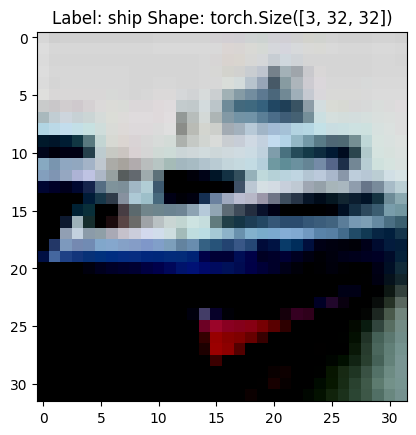

In [35]:
image, label = cifar10_test[1]

plt.title(f"Label: {classes[label]} Shape: {image.shape}")
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

In [36]:
image.shape

torch.Size([3, 32, 32])

In [37]:
image = image[None, :, :, :,]
image.shape

torch.Size([1, 3, 32, 32])

In [44]:
model_predict = classes[best_model(image).argmax().item()]
print(f"It is - '{classes[label]}', model think it is '{model_predict}'")

It is - 'ship', model think it is 'ship'
